## [1. Import Needed Modules](#import) ##
## [2 Concept for Callback Approach](#concept) ##
## [3. Define function to print text in rgb foreground and background colors](#pc) ##
## [4. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [5. Trim the trainning set](#Balance) ##
## [6. Create train, test and validation generators](#generators) ## 
## [7. Create a function to show Training Image Samples](#show) ## 
## [8. Create the Model](#model) ## 
## [9. Create a custom Keras callback to continue or halt training](#callback) ## 
## [10. Instantiate custom callback ](#callbacks) ##
## [11. Train the model](#train) ##
## [12. Define a function to plot the training data](#plot) ##
## [13. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [14 Save the model](#save) ##


<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

<a id="concept"></a>
# <center>Custom Callback Concept</center>
This notebook implements a custom callback to adjust the learning rate during training.  
The callback has a parameter dwell. If dwell is set to True, the callback monitors the  
validation loss. It keeps track of the lowest validation loss thus far achieved as you run  
through each epoch and stores this as the lowest loss and also stores the weights for that  
epoch as the best weights. At the end of an epoch the validation loss for that epoch is  
compared with the lowest loss. If the validation loss at the end of the current epoch is  
less than the lowest loss than it becomes the lowest loss and the weights of the current  
epoch become the best weights  
  
If the validation loss at the end of the current epoch is greator than the lowest loss    
this implies you have moved to a location in Nspace(N is the number of trainable parameters    
on the validation cost function surface that is less favorable(higher cost) than the position  
in Nspace defined by the best weights. Therefore why move the models weights to this less  
favorable location? Better to reset the models weights to the best weights, then lower the  
learning rate and run more epochs. The new learning rate is set to new_lr=current_lr * factor  
where factor is a user specified parameter in the instantiation of the callback. By default  
it is set to .04 and by default dwell is set to True.  
  
At the end of training the callback always returns your model with the weights set to the  
best weights. The callback provides a feature where it periodically queries the user to  
either contine and optionally manually specify a new learning rate or halt training.  
During training the calback provides useful information on the percent improvement in the  
validation loss for each epoch. The is useful to decide when to halt training or manually  
specifying a new learning rate.  

<a id="pc"></a>

<a id="pc"></a>
## <center>Define a function to print text in specified rgb foreground and background colors</center>
### Add some PZAZZ to your printed output with this function  
form of the call is:  print_in_color(txt_msg, fore_tupple, back_tupple where:
* txt_msg is the string to be printed out  
* fore_tuple is tuple of the form (r,g,b) specifying the foreground color of the text
* back_tuple is tuple of the form (r,g,b) specifying the background color of the text

In [2]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



<a id="makedf"></a>
# <center>Read in train, test and valid images and create train, test and validation data frames</center>
## using train, test and valid directories

In [3]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )       
    for klass in classlist:
        classpath=os.path.join(sdir, klass)           
        flist=sorted(os.listdir(classpath)) 
        desc=f'{klass:25s}'
        for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts()) 
    print(counts[0], type(counts[0]))
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'../input/agricultural-crops-image-classification/Agricultural-crops'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)
    

wheat                    : 100%|███████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 262144.00files/s]


number of classes in processed dataset=  30
27 <class 'int'>
the maximum files in any class in train_df is  27   the minimum files in any class in train_df is  15
train_df length:  580   test_df length:  125   valid_df length:  124
average image height=  370   average image width=  521  aspect ratio h/w=  0.710172744721689


<a id="trim"></a>
## <center>Trim train_df so no class has more than max_amples images </center>
## This function is not used in this notebook

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

#max_samples=300
#min_samples=300
#column='labels'
#train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

<a id="balance"></a>
## <center>Expand train_df rows with augmented images so each class has 200 samples</center>


In [5]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 


n=120 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,280) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)  


Initial length of dataframe is  580
Found 16 validated image filenames.      for class        Fox_nut(Makhana)        creating  104  augmented images 
Found 20 validated image filenames.      for class          mustard-oil           creating  100  augmented images 
Found 22 validated image filenames.      for class             Cherry             creating  98   augmented images 
Found 19 validated image filenames.      for class      vigna-radiati(Mung)       creating  101  augmented images 
Found 17 validated image filenames.      for class              gram              creating  103  augmented images 
Found 18 validated image filenames.      for class            coconut             creating  102  augmented images 
Found 27 validated image filenames.      for class      Pearl_millet(bajra)       creating  93   augmented images 
Found 16 validated image filenames.      for class              jute              creating  104  augmented images 
Found 18 validated image filenames.      for

<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [6]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 3600 validated image filenames belonging to 30 classes.          for train generator 
Found 124 validated image filenames belonging to 30 classes.           for valid generator 
Found 125 validated image filenames belonging to 30 classes.           for test generator 
test batch size:  25   test steps:  5  number of classes :  30


<a id="show"></a>
# <center>Create a function to show example training images</center>

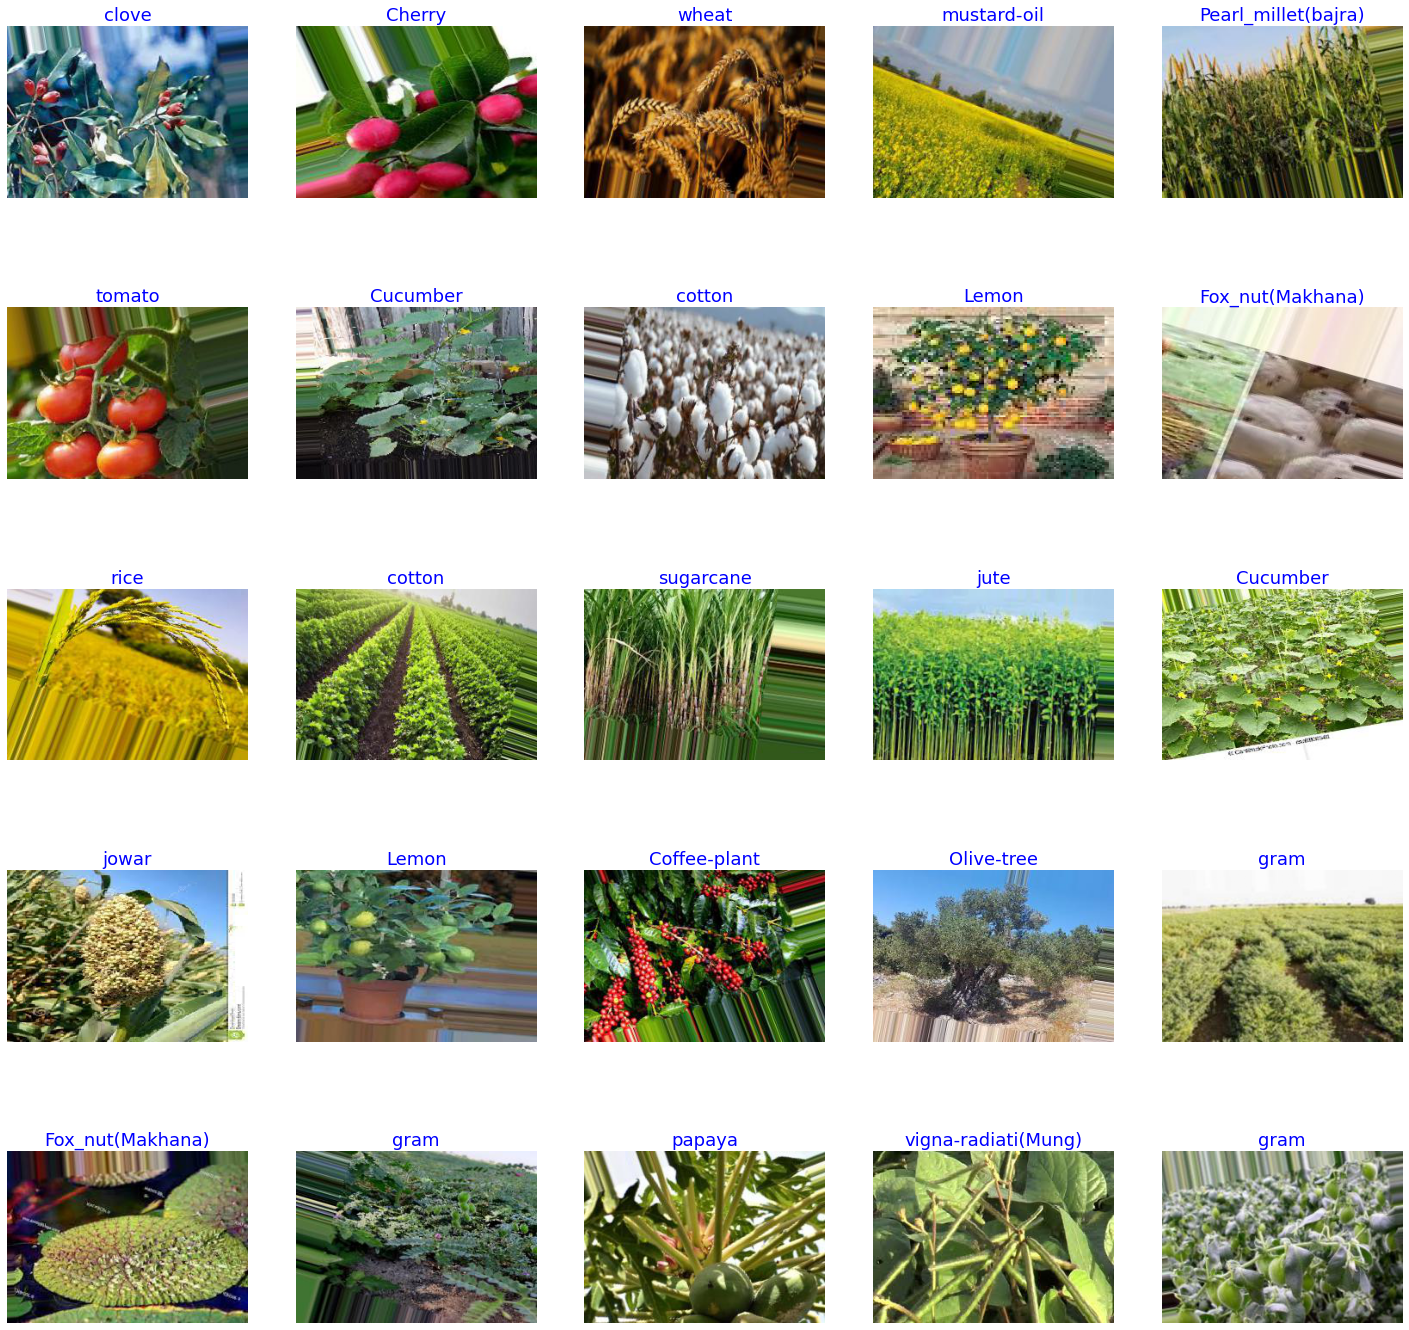

In [7]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning.   
### Then train for some number of epochs then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [8]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

43950080/43941136 [==============================] - 0s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [9]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [10]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning
### The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.  
### I have done a lot of testing running both ways hand have always found this to be true

In [11]:

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
120/120 [==============================] - 79s 495ms/step - loss: 8.4971 - accuracy: 0.6128 - val_loss: 7.4403 - val_accuracy: 0.6694

 validation loss of  7.4403 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

Epoch 2/40
120/120 [==============================] - 57s 470ms/step - loss: 5.7103 - accuracy: 0.9678 - val_loss: 5.5520 - val_accuracy: 0.8065

 validation loss of  5.5520 is 25.3791 % below lowest loss, saving weights from epoch 2   as best weights

Epoch 3/40
120/120 [==============================] - 57s 471ms/step - loss: 4.2810 - accuracy: 0.9944 - val_loss: 4.3375 - val_accuracy: 0.7984

 validation loss of  4.3375 is 21.8754 % below lowest loss, saving weights from epoch 3   as best weights

Epoch 4/40
120/12

 5


you entered 5 Training will continue to epoch 15

Epoch 11/40
120/120 [==============================] - 56s 469ms/step - loss: 0.5070 - accuracy: 1.0000 - val_loss: 1.0879 - val_accuracy: 0.8387

 validation loss of  1.0879 is  3.9927 % below lowest loss, saving weights from epoch 11  as best weights

Epoch 12/40
120/120 [==============================] - 56s 468ms/step - loss: 0.4538 - accuracy: 1.0000 - val_loss: 1.0264 - val_accuracy: 0.8226

 validation loss of  1.0264 is  5.6526 % below lowest loss, saving weights from epoch 12  as best weights

Epoch 13/40
120/120 [==============================] - 56s 469ms/step - loss: 0.4147 - accuracy: 1.0000 - val_loss: 0.9935 - val_accuracy: 0.8387

 validation loss of  0.9935 is  3.2088 % below lowest loss, saving weights from epoch 13  as best weights

Epoch 14/40
120/120 [==============================] - 56s 468ms/step - loss: 0.3904 - accuracy: 1.0000 - val_loss: 0.9963 - val_accuracy: 0.8306

 validation loss of  0.9963 is  0.2840 % 

 h


you entered h,  Training halted on epoch 15 due to user input


loading model with weights from epoch 15

training elapsed time was 0.0 hours, 15.0 minutes, 9.09 seconds)



<a id="plot"></a>
# <center>Define a function to plot the training data

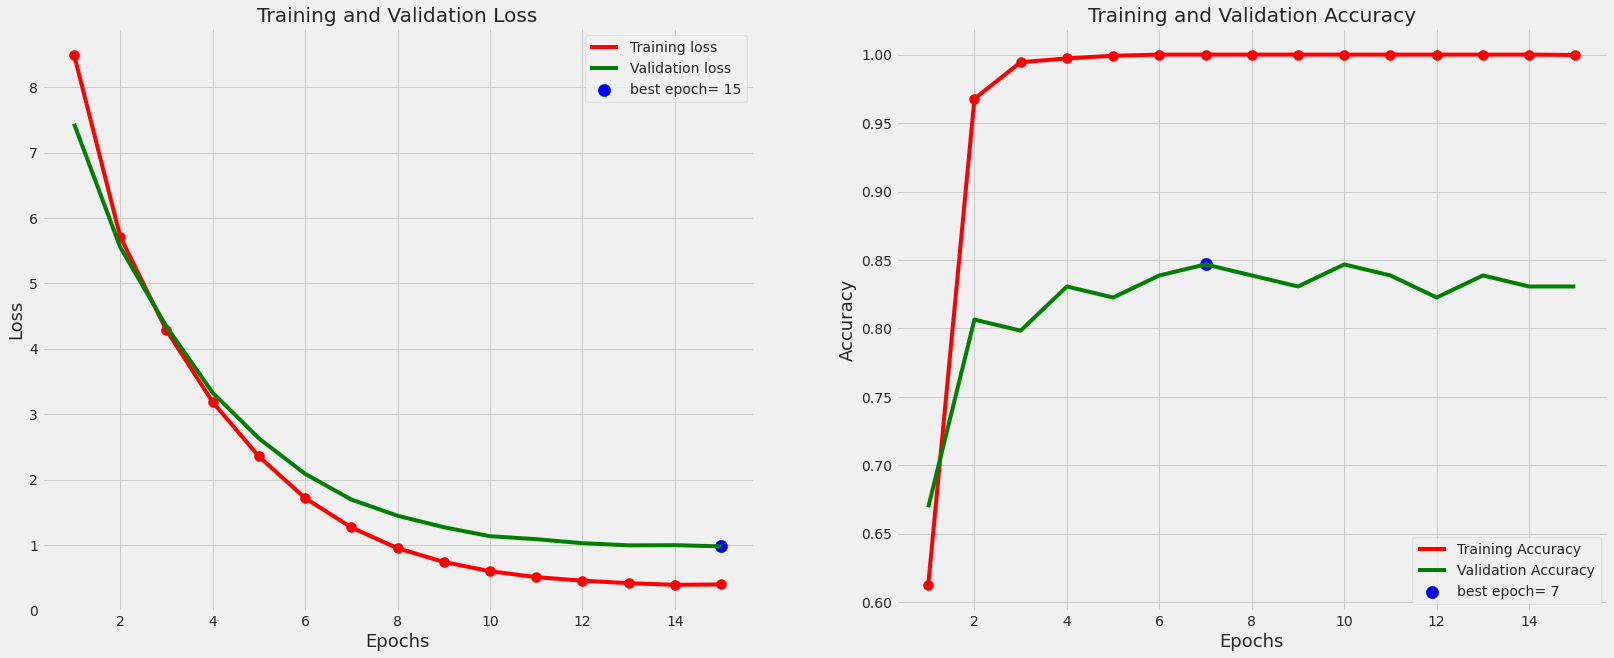

In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

<a> id="result"</a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

5/5 [==============================] - 5s 270ms/step
there were 18 errors in 125 tests for an accuracy of  85.60



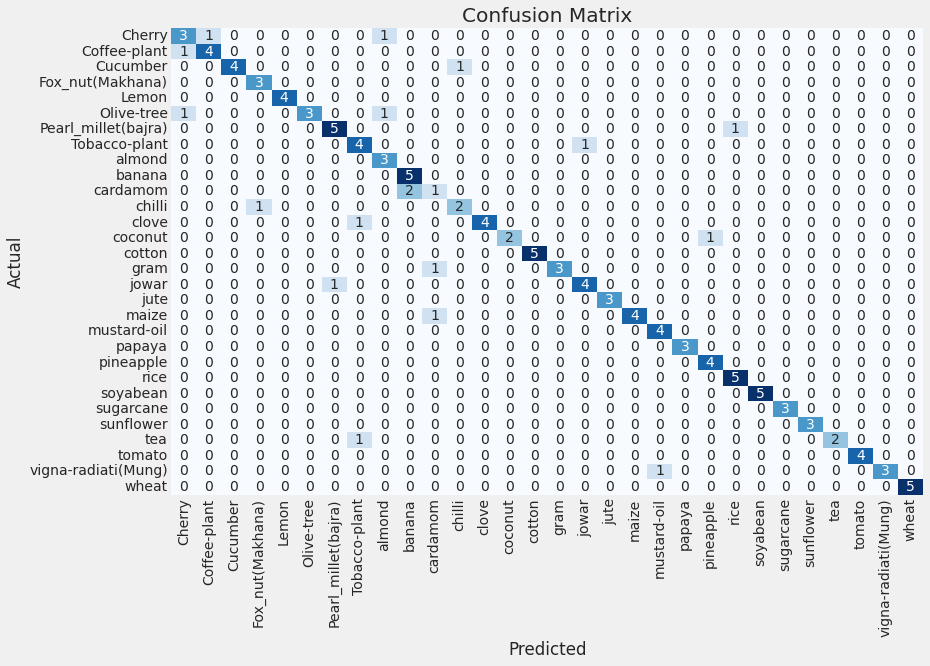

Classification Report:
----------------------
                      precision    recall  f1-score   support

             Cherry     0.6000    0.6000    0.6000         5
       Coffee-plant     0.8000    0.8000    0.8000         5
           Cucumber     1.0000    0.8000    0.8889         5
   Fox_nut(Makhana)     0.7500    1.0000    0.8571         3
              Lemon     1.0000    1.0000    1.0000         4
         Olive-tree     1.0000    0.6000    0.7500         5
Pearl_millet(bajra)     0.8333    0.8333    0.8333         6
      Tobacco-plant     0.6667    0.8000    0.7273         5
             almond     0.6000    1.0000    0.7500         3
             banana     0.7143    1.0000    0.8333         5
           cardamom     0.3333    0.3333    0.3333         3
             chilli     0.6667    0.6667    0.6667         3
              clove     1.0000    0.8000    0.8889         5
            coconut     1.0000    0.6667    0.8000         3
             cotton     1.0000    1.0

In [14]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

In [16]:
if len(error_list) > 0 and len(error_list)<50:
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))
    sorted_list=sorted(error_list)
    for i in range(len(sorted_list)):
        fpath=sorted_list[i]        
        split=fpath.split('/')        
        f=split[4]+ '-' + split[5]
        print(f'{f:^30s}{error_pred_list[i]:^30s}')
        

Below is a list of test files that were miss classified 

          Test File                    Predicted as         
     Cherry-image20.jpeg              Tobacco-plant         
     Cherry-images21.jpg                 cardamom           
  Coffee-plant-images10.jpg               jowar             
   Cucumber-image (30).jpg                almond            
  Olive-tree-image (12).jpg               Cherry            
   Olive-tree-image (9).jpg              cardamom           
Pearl_millet(bajra)-image (56).jpg          pineapple           
  Tobacco-plant-images41.jpg              banana            
   cardamom-image (7).jpeg                banana            
   cardamom-image (8).jpeg             mustard-oil          
     chilli-image11.jpeg              Tobacco-plant         
      clove-image16.jpeg                  Cherry            
    coconut-image (11).jpg         Pearl_millet(bajra)      
     gram-image (15).jpg                  almond            
     jowar-image (2).jp

<a id="save"></a>
# <center>Save the model

In [17]:
working_dir=r'./'
subject='crops' 
save_id=f'{subject}-{f1score:5.2f}.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
msg= f'model was saved as {model_save_loc}'
print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

model was saved as ./crops-85.62.h5

